In [1]:
from networks import ConvNet
from utils import get_default_convnet_setting
net_width, net_depth, net_act, net_norm, net_pooling = get_default_convnet_setting()
model = ConvNet(channel=3, num_classes=128, net_depth=net_depth, net_act=net_act, net_width=net_width, net_norm=net_norm, net_pooling=net_pooling)
print(model)

/home/sjoshi/anaconda3/envs/distillation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sjoshi/anaconda3/envs/distillation/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(128, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(128, 128, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(128, 128, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Linear(in_features=2048, out_features=128, bias=True)
)


In [2]:
import torch
import torchvision 
from torchvision import transforms
from PIL import Image

def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort


CACHED_MEAN_STD = {
    'cifar10': ((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    'cifar100': ((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    'stl10': ((0.4467, 0.4398, 0.4066), (0.2603, 0.2566, 0.2713)),
    'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    'mnist':((0.1307), (0.3081))
}

transform_train = transforms.Compose([
        #transforms.RandomResizedCrop((32,32), interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        ColourDistortion(s=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD["cifar100"])
    ])

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*CACHED_MEAN_STD["cifar100"])])
dataset = torchvision.datasets.CIFAR10("/data", train=True, transform=transform)

In [3]:
labels_all = torch.load("/home/sjoshi/mtt-distillation/target_rep/CIFAR100/train_rep_r50_128_dim.pt", map_location="cpu")


In [4]:
class SoftLabelDataset(torch.utils.data.Dataset):
    def __init__(self, img_dataset, label_tensor, subset_idx=None):
        super().__init__()
        self.img_dataset = img_dataset
        self.label_tensor = label_tensor
        assert len(self.img_dataset) == len(self.label_tensor)
        self.subset_idx = subset_idx
        if self.subset_idx is None:
            self.subset_idx = range(len(self.img_dataset))
        
    def __getitem__(self, i):
        idx = self.subset_idx[i]
        return (self.img_dataset[idx][0], self.label_tensor[idx])
    
    def __len__(self):
        return len(self.subset_idx)
    
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, img_tensor, label_tensor, subset_idx=None):
        super().__init__()
        self.img_tensor = img_tensor
        self.label_tensor = label_tensor
        assert len(self.img_tensor) == len(self.label_tensor)
        self.subset_idx = subset_idx
        if self.subset_idx is None:
            self.subset_idx = range(len(self.img_tensor))
        
    def __getitem__(self, i):
        idx = self.subset_idx[i]
        return (self.img_tensor[idx], self.label_tensor[idx])
    
    def __len__(self):
        return len(self.subset_idx)

In [5]:
import random 
import pickle 

with open("/home/sjoshi/mtt-distillation/sorted_idx/sorted_indices_CIFAR100.pkl", "rb") as f:
    loss_ranking = pickle.load(f)
    
with open("/home/sjoshi/mtt-distillation/init/cifar100/random_50ipc.pkl", "rb") as f:
    subset_idx = pickle.load(f)
#subset_idx = random.sample(range(50000), 50000)
# with open("/data/file_transfer/cifar100-0.02-kmeans-sas-indices.pkl", "rb") as f:
#     subset_idx = pickle.load(f)
# with open("/home/sjoshi/mtt-distillation/init/cifar100/random_10ipc.pkl", "rb") as f:
#     subset_idx = pickle.load(f)
dst_train = SoftLabelDataset(dataset, labels_all, subset_idx)
print("length of dset", len(dst_train))

length of dset 5000


In [43]:
images_init = torch.load("/home/sjoshi/mtt-distillation/logged_files/CIFAR100/2024-01-15_16:17:53None/images_1.pt")
labels_init = torch.load("/home/sjoshi/mtt-distillation/logged_files/CIFAR100/2024-01-15_16:17:53None/labels_1.pt")
# images_syn = torch.load("/home/sjoshi/krrst_orig/results/2024-01-0814:46:15.950178_CIFAR100_random_5000_new_arch/x_syn_final.pt")
# labels_syn = torch.load("/home/sjoshi/krrst_orig/results/2024-01-0814:46:15.950178_CIFAR100_random_5000_new_arch/y_syn_final.pt")

images_best = torch.load("/home/sjoshi/mtt-distillation/logged_files/CIFAR100/2024-01-15_16:17:53None/images_100.pt")
labels_best = torch.load("/home/sjoshi/mtt-distillation/logged_files/CIFAR100/2024-01-15_16:17:53None/labels_100.pt")
# # images_init = torch.load("/home/sjoshi/krrst_orig/results/2024-01-0814:47:42.550038_CIFAR100_high_loss_5000_new_arch/x_syn_initial.pt")
# # labels_init = torch.load("/home/sjoshi/krrst_orig/results/2024-01-0814:47:42.550038_CIFAR100_high_loss_5000_new_arch/y_syn_initial.pt")
# # # images_syn = torch.load("/home/sjoshi/krrst_orig/results/2024-01-0814:47:42.550038_CIFAR100_high_loss_5000_new_arch/x_syn_final.pt")
# # # labels_syn = torch.load("/home/sjoshi/krrst_orig/results/2024-01-0814:47:42.550038_CIFAR100_high_loss_5000_new_arch/y_syn_final.pt")


dst_train = TensorDataset(images_init, labels_init)

In [7]:
def rescale(tensor_img):
    tensor_img = tensor_img.clone()
    rescaled_imgs = torch.empty_like(tensor_img)
    mean, std = CACHED_MEAN_STD["cifar100"]
    for i, (t, m, s) in enumerate(zip(tensor_img, mean, std)):
        rescaled_imgs[i] = t.mul(s).add(m)
    rescaled_imgs[rescaled_imgs < 0] = 0
    rescaled_imgs[rescaled_imgs > 1] = 1
    display(transforms.ToPILImage()(rescaled_imgs).resize((96,96)))

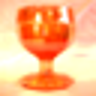

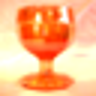

tensor(0.0078)


In [25]:
i = 13
rescale(images_init[i])
rescale(images_best[i])
print(torch.mean(torch.abs(images_best[i] - images_init[i])))

In [44]:
from networks import ConvNet
from utils import get_default_convnet_setting
trainloader = torch.utils.data.DataLoader(dst_train, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
device = torch.device("cuda:5")
net_width, net_depth, net_act, net_norm, net_pooling = get_default_convnet_setting()
model = ConvNet(channel=3, num_classes=128, net_depth=net_depth, net_act=net_act, net_width=net_width, net_norm=net_norm, net_pooling=net_pooling)
print(len(dst_train))

5000


In [27]:
from typing import Any
from torch.utils.data import Dataset 

class ChangeLabels(Dataset):
    def __init__(self, dataset, new_labels):
        super().__init__()
        self.dataset = dataset 
        self.new_labels = new_labels
        
    def __getitem__(self, index: Any) -> Any:
        return self.dataset[index][0], self.new_labels[index]
    
    def __len__(self):
        return len(self.dataset)
        
    

In [32]:
kmeans_256 = torch.load("/home/sjoshi/mtt-distillation/target_rep/CIFAR100/train_rep_kmeans_256_plabels.pt")

In [33]:
dst_train = ChangeLabels(dataset, kmeans_256)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

In [45]:
from torch import nn, optim
import torch.nn.functional as F 
from tqdm import tqdm, trange
from utils import ParamDiffAug

dsa_param = ParamDiffAug()
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()

model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
pbar = trange(20, desc="pre-training")
for epoch in pbar:
    loss_avg, num_exp = 0, 0
    for datum in trainloader:
        img = datum[0].float().to(device)
        lab = datum[1].float().to(device)
        #lab = datum[1].to(device)
        #indices = indices.to(device)
        
        n_b = img.shape[0]

        output = model(img)
        
        loss = criterion(output, lab)
                
        loss_avg += loss.item()*n_b
        num_exp += n_b

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_avg /= num_exp
    pbar.set_postfix_str(f"loss: {loss_avg}")

pre-training: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s, loss: 0.5243302727699279]


In [178]:
from typing import Any
from torch.utils.data import Dataset 
class DatasetWithIndices(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()
        self.dataset = dataset
    
    def __getitem__(self, index: Any) -> Any:
        return index, self.dataset[index]

    def __len__(self):
        return len(self.dataset)
metric_trainloader = torch.utils.data.DataLoader(DatasetWithIndices(dataset), batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

In [109]:
from torch import nn, optim
from tqdm import tqdm 
import torch.nn.functional as F


model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.24195 momentum=0.9, weight_decay=1e-3)
pbar = tqdm(range(80), desc="pre-training")
for epoch in pbar:
    loss_avg, num_exp = 0, 0
    for idx, datum in metric_trainloader:
        img = datum[0].float().to(device)
        n_b = img.shape[0]
        student_z = model(img)
        
        student_dist = F.cosine_similarity(student_z.unsqueeze(1), student_z.unsqueeze(0), dim=2)
        teacher_z = labels_all[idx].to(device)
        teacher_dist = F.cosine_similarity(teacher_z.unsqueeze(1), teacher_z.unsqueeze(0), dim=2)
        loss = torch.log(torch.sum(torch.exp(student_dist - teacher_dist)))

        loss_avg += loss.item()
        num_exp += n_b

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_avg /= num_exp
    pbar.set_postfix_str(f"loss: {loss_avg}")

pre-training:   0%|          | 0/80 [00:00<?, ?it/s]


NameError: name 'metric_trainloader' is not defined

In [50]:
from torch.utils.data import Subset 
import random

untrained_model = ConvNet(channel=3, num_classes=128, net_depth=net_depth, net_act=net_act, net_width=net_width, net_norm=net_norm, net_pooling=net_pooling)
untrained_model = untrained_model.to(device)
Z = []
Y = []
random.seed(0)
random_subset = list(random.sample(range(50000), 50000))
clf_cifar100 = Subset(torchvision.datasets.CIFAR100("/data", transform=transform), indices=random_subset)
clf_dataloader = torch.utils.data.DataLoader(clf_cifar100, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
with torch.no_grad():
    for X, y in tqdm(clf_dataloader, desc="encoding"):
        Z.append(model.features(X.to(device)).view(-1, 2048))
        #Z.append(model(X.to(device)))
        Y.append(y.to(device))
Z = torch.cat(Z, dim=0)
Y = torch.cat(Y, dim=0)
print(Z.shape)
print(Y.shape)

encoding: 100%|██████████| 196/196 [00:02<00:00, 74.33it/s]

torch.Size([50000, 2048])
torch.Size([50000])


In [46]:
def train_clf(X, y, representation_dim, num_classes, device, reg_weight=1e-3, iter=500):
    print('\nL2 Regularization weight: %g' % reg_weight)

    criterion = nn.CrossEntropyLoss()
    n_lbfgs_steps = iter

    # Should be reset after each epoch for a completely independent evaluation
    clf = nn.Linear(representation_dim, num_classes).to(device)
    clf_optimizer = optim.LBFGS(clf.parameters())
    clf.train()

    t = tqdm(range(n_lbfgs_steps), desc='Loss: **** | Train Acc: ****% ', bar_format='{desc}{bar}{r_bar}')
    for _ in t:
        def closure():
            clf_optimizer.zero_grad()
            raw_scores = clf(X)
            loss = criterion(raw_scores, y)
            loss += reg_weight * clf.weight.pow(2).sum()
            loss.backward()

            _, predicted = raw_scores.max(1)
            correct = predicted.eq(y).sum().item()

            t.set_description('Loss: %.3f | Train Acc: %.3f%% ' % (loss, 100. * correct / y.shape[0]))

            return loss

        clf_optimizer.step(closure)

    return clf


def test_clf(testloader, device, net, clf, feature=False):
    criterion = nn.CrossEntropyLoss()
    net.eval()
    clf.eval()
    test_clf_loss = 0
    correct = 0
    total = 0
    acc_per_point = []
    with torch.no_grad():
        t = tqdm(enumerate(testloader), total=len(testloader), desc='Loss: **** | Test Acc: ****% ',
                 bar_format='{desc}{bar}{r_bar}')
        for batch_idx, (inputs, targets) in t:
            inputs, targets = inputs.to(device), targets.to(device)
            representation = None
            if feature:
                representation = net.features(inputs).view(-1, 2048)
            else:
                #representation = net.features(inputs).view(-1, 2048)
                representation = net(inputs)
            # test_repr_loss = criterion(representation, targets)
            raw_scores = clf(representation)
            clf_loss = criterion(raw_scores, targets)
            test_clf_loss += clf_loss.item()
            _, predicted = raw_scores.max(1)
            total += targets.size(0)
            acc_per_point.append(predicted.eq(targets))
            correct += acc_per_point[-1].sum().item()
            t.set_description('Loss: %.3f | Test Acc: %.3f%% ' % (test_clf_loss / (batch_idx + 1), 100. * correct / total))
            
    acc = 100. * correct / total
    return acc, torch.cat(acc_per_point, dim=0).cpu().numpy()

def top5accuracy(output, target, topk=(5,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        print(correct)
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [47]:
cifar100_test = torchvision.datasets.CIFAR100("/data", train=False, transform=transform)
testloader = torch.utils.data.DataLoader(cifar100_test, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

In [51]:
clf = train_clf(Z, Y, Z.shape[1], 100, device, iter=100)


L2 Regularization weight: 0.001


Loss: 1.972 | Train Acc: 65.562% : ██████████| 100/100 [00:17<00:00,  5.65it/s]


In [52]:
acc, acc_per_point = test_clf(testloader, device, model, clf, feature=True)
#acc, acc_per_point = test_clf(clf_dataloader, device, model, clf, embed=False)

Loss: 2.240 | Test Acc: 44.480% : ██████████| 40/40 [00:00<00:00, 60.74it/s]


In [ ]:
random_subset = random.sample(range(50000), 1000)
clf = train_clf(labels_all.to(device)[random_subset], torch.tensor([dataset[i][1] for i in range(50000)]).to(device)[random_subset], labels_all.shape[1], 100, device, iter=500)


In [ ]:
test_labels = torch.load("/home/sjoshi/mtt-distillation/target_rep/CIFAR100/test_rep_r50_128_dim.pt", map_location=device)

In [ ]:
from torch.utils.data import Subset 
import random

test_Z = []
random.seed(0)
with torch.no_grad():
    for X, y in tqdm(testloader, desc="encoding"):
        #test_Z.append(model.features(X.to(device)).view(-1, 2048))
        test_Z.append(model(X.to(device)))
test_Z = torch.cat(test_Z, dim=0)

encoding: 100%|██████████| 40/40 [00:00<00:00, 48.16it/s]


In [ ]:
train_mse_losses = []
for i in range(50000):
    train_mse_losses.append(torch.norm(Z[i].cpu() - labels_all[i]).item())

RuntimeError: The size of tensor a (2048) must match the size of tensor b (128) at non-singleton dimension 0

In [29]:
cifar100_test_labels = [cifar100_test[i][1] for i in range(len(cifar100_test))]

In [ ]:
test_acc_per_point = []
with torch.no_grad():
    for i in range(10000):
        pred = torch.argmax(model(test_labels[i].unsqueeze(dim=0))[0]).item()
        test_acc_per_point.append(pred == cifar100_test_labels[i])
print(np.mean(test_acc_per_point))

In [34]:
import numpy as np 
test_acc_per_point = []
with torch.no_grad():
    for i in range(10000):
        pred = torch.argmax(model(cifar100_test[i][0].unsqueeze(dim=0).to(device))[0]).item()
        test_acc_per_point.append(pred == cifar100_test_labels[i])
print(np.mean(test_acc_per_point))

0.4672


In [ ]:
import numpy as np 

with open("/home/sjoshi/mtt-distillation/sorted_idx/cifar100_r34_fscores_epoch_200.pkl", "rb") as f:
    loaded = pickle.load(f)
    fscore = np.zeros(50000)
    fscore[np.array(loaded["indices"])] = loaded["forgetting counts"]
    

In [ ]:
correct = [i for i in range(10000) if acc_per_point[i]]
wrong = [i for i in range(10000) if not acc_per_point[i]]

In [ ]:
test_representations = []
with torch.no_grad():
    for X, y in tqdm(testloader):
        test_representations.append(model.features(X.to(device)).view(-1, 2048))
    test_representations = torch.cat(test_representations, dim=0)

100%|██████████| 40/40 [00:01<00:00, 22.84it/s]


In [ ]:
with torch.no_grad():
    syn_representations = model.features(images_best.to(device)).view(-1, 2048)

In [ ]:
with open("init/cifar100/random_50ipc_2.pkl", "rb") as f:
    syn_idx = pickle.load(f)

In [ ]:
partition_syn = {}
for i in range(100):
    partition_syn[i] = []
for i, j in enumerate(syn_idx):
    partition_syn[dataset[j][1]].append(i)

In [ ]:
sim_to_same_syn = []
sim_to_diff_syn = []
for i in tqdm(range(10000)):
    test_label = cifar100_test_labels[i]
    sim_to_same_syn.append(torch.mean(test_representations[i:i+1] @ syn_representations[partition_syn[test_label]].T).item())
    curr_diff_sim = []
    for j in range(100):
        if j == test_label:
            continue
        curr_diff_sim.append(torch.mean(test_representations[i:i+1] @ syn_representations[partition_syn[j]].T).item())
    sim_to_diff_syn.append(np.mean(curr_diff_sim))
sim_to_same_syn = np.array(sim_to_same_syn)
sim_to_diff_syn = np.array(sim_to_diff_syn)

100%|██████████| 10000/10000 [01:40<00:00, 99.80it/s]


In [ ]:
print(np.mean(sim_to_same_syn[correct]), np.std(sim_to_same_syn[correct]))
print(np.mean(sim_to_same_syn[wrong]), np.std(sim_to_same_syn[wrong]))

535.5304243683565 50.099814491966114
493.80743034756665 37.59873036435433


In [ ]:
print(np.mean(sim_to_diff_syn[correct]))
print(np.mean(sim_to_diff_syn[wrong]))

458.11616229930604
459.4665628371746


In [ ]:
def combine_images(left_image, right_image):
    # Ensure both images have the same shape
    assert left_image.shape == right_image.shape, "Images must have the same shape"

    # Get the width of the images
    width = left_image.shape[2]

    # Split the images into left and right halves
    left_half = left_image[:, :, :width // 2]
    right_half = right_image[:, :, width // 2:]

    # Concatenate the left and right halves to create the combined image
    combined_image = torch.cat([left_half, right_half], dim=2)

    return combined_image

In [ ]:
def interpolate_acc(class_num):
    correct = 0
    total = 0
    for i in partition_syn[class_num]:
        for j in partition_syn[class_num]:
            if i == j:
                continue 
            total += 1
            interpolated_image = combine_images(images_best[i], images_best[j]).unsqueeze(dim=0).to(device)
            with torch.no_grad():
                if torch.argmax(clf(model.features(interpolated_image).view(-1, 2048))[0]).item() == class_num:
                    correct += 1
                    
    return correct / total * 100
            

In [ ]:
interpolated_accs = [interpolate_acc(i) for i in range(100)]

68.75952658321724